*press Shift + Enter to run each block*.

# Problem Definition

## Overview
A telecom network typically consists of multiple nodes connected to each other. These nodes are network devices that, like any other electronic devices, are subject to issues affecting their performance. Such issues could be overheating, unavailability of service, quality of service degradation, traffic congestion …etc.

Each node generates reporting data about its performance. This reporting happens through counters, which you can think of as sensors that report different operation states via numbers.

The BigModel is a machine learning classifier that once fed with the right data, it will automatically classify the issues experienced by each node. Sample dataset for the input and output of the BigModel is available. 

## BigModel inputs and outputs
### Inputs:
* node_no
* hour	
* month	
* day
* year
* Bandwidth
* counter_0, ... counter_51

### Outputs:
* node_no
* month	
* day
* Bandwidth
* Issue_no


## Required
Designing and Implement a black box adversarial attack on the BigModel.

# What type of black box adverserial attack to implement?

## Important observations
1. The attack must be offline.
2. I don't understand the physical meaning/unit each counter represents.
3. I only have ONE label per day per node. It's either a multiclass problem with distinct classes or a multilabel problem with a selector (postprocessing) that selects one issue among the outputs.

## Substitute model attack (The chosen method)
as mentioned in https://arxiv.org/pdf/1611.03814.pdf
### How?
* The adversary can create a substitute model (surrogate/auxiliary model) to mount attacks on the victim system. 
* The adversary can use a substitute model to test potential inputs before submitting them to the victim system. 
### Properties
* The simplest and arguably weakest attack on training.
* Accesses a summary, partial or all of the training data. 
* These attacks are offline attempts at model reconnaissance
* Used to undermine privacy.

## label-only attack 
As presented in https://arxiv.org/abs/1804.08598
### How?
1. Add random noise that doesn’t alter the meaning of the data (image). *This is a major point, as for humans the image of a cat will stay a cat, but not for the model.
2. Pass the altered image to the targeted model.
3. A list of labels will be outputed. Now give your example the order it got from the output. In out case *how "dog" is the cat photo?*
4. Repeat from 1 till you find the highest order.

### Why I won't use this?
* In our case, It is hard to do something similar without understanding each counter. We can easily know a cat's image after adding noise to it, but for the counters there is no clear intuition.



In [2]:
# Importing all the needed libraries
import pandas as pd
import numpy as np
import os.path as path

#Importing visual libraries for ploting
import matplotlib.pyplot as pyplot

#Importing for preprocessing
from sklearn.model_selection import train_test_split 
import keras.utils
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder


Using TensorFlow backend.


### *Important note before loading the data:*
Make sure that "Input Dataset.csv" and "Output Dataset.csv" files are in C:\Users\YOUR_USERNAME

If not, you can always change `pd.read_csv("Input Dataset.csv")` to `pd.read_csv(r'FILEPATH_WHERE_THE_FILE_AT\input_mod.csv')`

# First: Data Exploration and understanding
### Calculate the mean for values from counter_40 till counter_51


In [3]:
def get_mean(s):
    s= s.replace('[', '').replace(']', '').replace(' ', '').split(",")
    mean = pd.to_numeric(s).mean()
    return mean

def get_counters_mean():
    X_raw = pd.read_csv("Input Dataset.csv")
    X_raw.iloc[:, 46:]= X_raw.iloc[:, 46:].applymap(get_mean)
    export_csv = X_raw.to_csv ("Input Dataset Mean.csv")
    return X_raw

### Load the data

In [4]:
def load_data():
    ## If the file with the mean was found
    if path.exists("Input Dataset Mean.csv"):
        X = pd.read_csv("Input Dataset Mean.csv")
    else:
        X = get_counters_mean()
        
    y = pd.read_csv("Output Dataset.csv")
    return X, y

In [5]:
input_data, output_data = load_data()

### Printing some information for each dataframe

In [6]:
print("The number of nulls in input dataframe = %d" %(input_data.isnull().any().sum()))
print("The number of nulls in output dataframe = %d\n" %(output_data.isnull().any().sum()))
print("Column information for input dataframe:") 
print(input_data.info())
print("\nColumn information for output dataframe:")
print(output_data.info())

The number of nulls in input dataframe = 0
The number of nulls in output dataframe = 0

Column information for input dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711432 entries, 0 to 711431
Data columns (total 58 columns):
node_no       711432 non-null int64
hour          711432 non-null int64
month         711432 non-null int64
day           711432 non-null int64
year          711432 non-null int64
Bandwidth     711432 non-null int64
counter_0     711432 non-null int64
counter_1     711432 non-null int64
counter_2     711432 non-null int64
counter_3     711432 non-null int64
counter_4     711432 non-null int64
counter_5     711432 non-null int64
counter_6     711432 non-null int64
counter_7     711432 non-null int64
counter_8     711432 non-null int64
counter_9     711432 non-null int64
counter_10    711432 non-null int64
counter_11    711432 non-null int64
counter_12    711432 non-null int64
counter_13    711432 non-null int64
counter_14    711432 non-null int64
count

### Visualization

Text(0, 0.5, 'Number of examples')

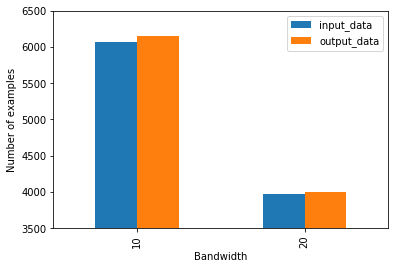

In [7]:
# X-axis: Bandwidth
# Y-axis: Number of examples in each file 
#
# Notes: 
# a. Number of examples in each file is not exactly equal
# b. Number of examples with Bandwidth 10 > Number of examples with Bandwidth 20

df = pd.DataFrame() 
df.insert(0, 'input_data', input_data.groupby('Bandwidth')['node_no'].nunique())
df.insert(0, 'output_data', output_data.groupby('Bandwidth')['node_no'].nunique())
ax = df.plot(y=["input_data", "output_data"], kind="bar")
ax.set_ylim(3500, 6500)
ax.set_ylabel("Number of examples")

Text(0, 0.5, 'Number of examples')

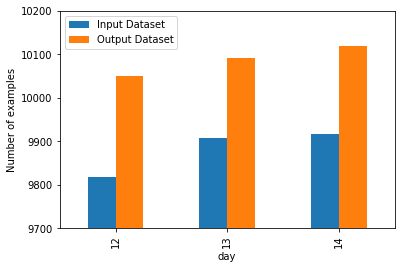

In [8]:
# X-axis: Days [12, 13, 14]
# Y-axis: Number of examples in the input and output files 
#
# Notes: 
# a. Number of examples between different days in each dataframe (input/ouput) is not constant
# b. Number of examples per day is not the same in the input and the output 

df = pd.DataFrame() 
df.insert(0, 'Input Dataset', input_data.groupby('day')['node_no'].nunique())
df.insert(0, 'Output Dataset', output_data.groupby('day')['node_no'].nunique())
ax = df.plot(y=["Input Dataset", "Output Dataset"], kind="bar")
ax.set_ylim(9700, 10200)
ax.set_ylabel("Number of examples")

Text(0, 0.5, 'Issue count')

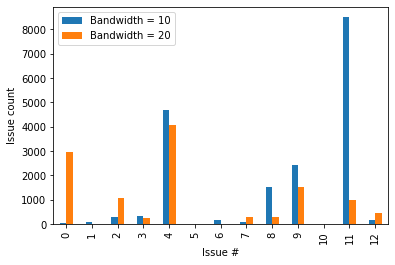

In [9]:
# X-axis: Issue numbers (labels)
# Y-axis: Number of examples in each bandwidth 
#
# Notes: 
# a. Clear case of "class imbalance" as we have more datapoints for issue #11 and #4 than the rest
# b. It is clear that "Bandwidth" is related to the issue #

df = pd.DataFrame() 
Issue_count = output_data[['Bandwidth','Issue_no']].groupby(['Bandwidth','Issue_no']).size().values
df.insert(0, 'Bandwidth = 10', Issue_count[0:13])
df.insert(1, 'Bandwidth = 20', Issue_count[13:])
ax = df.plot(y=['Bandwidth = 10', 'Bandwidth = 20'], kind="bar")
ax.set_xlabel("Issue #")
ax.set_ylabel("Issue count")

Text(0, 0.5, 'Issue count')

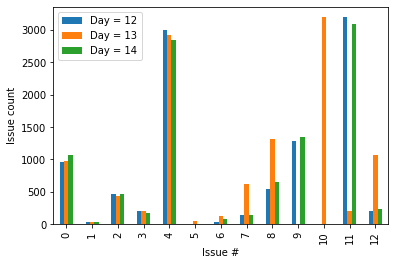

In [10]:
# X-axis: Issue numbers (labels)
# Y-axis: Number of examples in each day
#
# Notes: 
# a. It is clear that "day" is related to the issue #. For example, Issue #10 appears only in day 13 while issue # 9 doesn't appear in that day at all.
 

df = pd.DataFrame() 
Issue_count = output_data[['day','Issue_no']].groupby(['day','Issue_no']).size().values
df.insert(0, 'Day = 12', Issue_count[0:13])
df.insert(1, 'Day = 13', Issue_count[13:26])
df.insert(2, 'Day = 14', Issue_count[25:])
ax = df.plot(y=['Day = 12', 'Day = 13', 'Day = 14'], kind="bar")
ax.set_xlabel("Issue #")
ax.set_ylabel("Issue count")

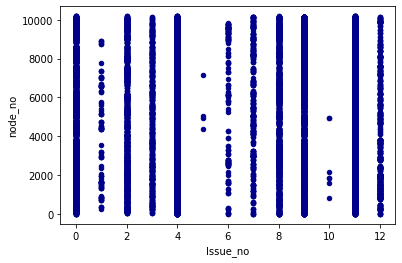

In [11]:
# X-axis: Issue numbers (labels)
# Y-axis: Node_no
#
# Notes: 
# a. Some Issue # don't occur in some nodes at all. for instance, node #8000 don't experience issues #1, #5, or #10
# b. Some Issue # are more common than others and occures in most of the nodes like issue #4, #11, and #9
 
output_data.plot.scatter(x='Issue_no', y='node_no', c='DarkBlue')

Text(0, 0.5, 'Number of examples')

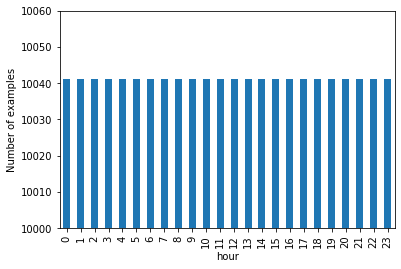

In [12]:
# X-axis: hours [0, 23]
# Y-axis: Number of examples in input data 
#
# Notes: 
# There is no missing data for 1 hour or more.

ax = input_data.groupby('hour')['node_no'].nunique().plot.bar()
ax.set_ylim(10000, 10060)
ax.set_ylabel("Number of examples")

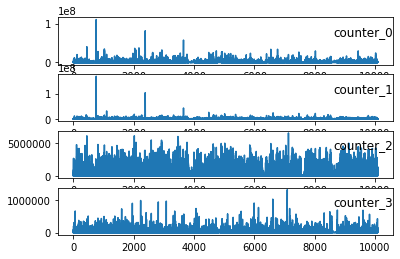

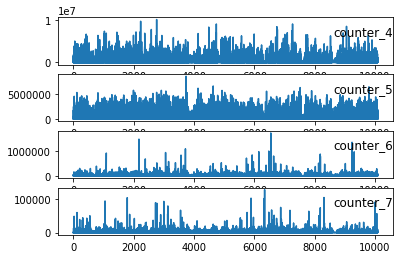

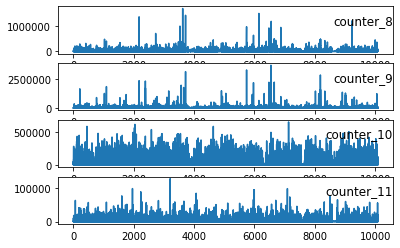

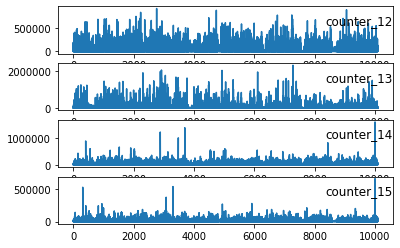

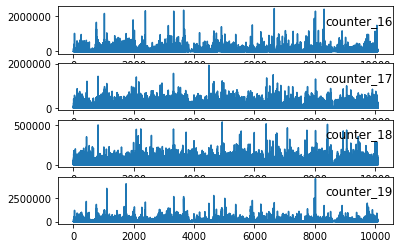

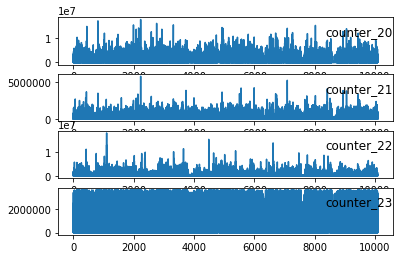

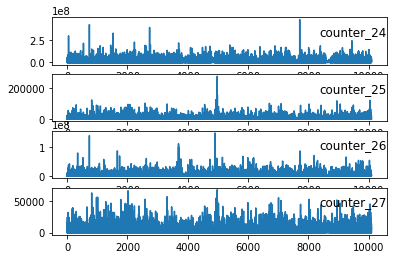

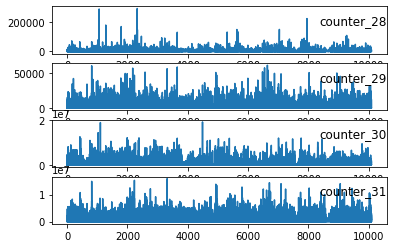

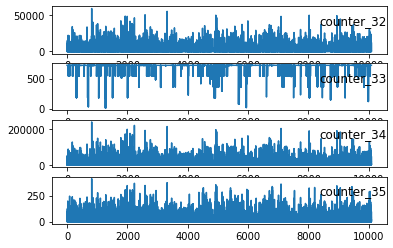

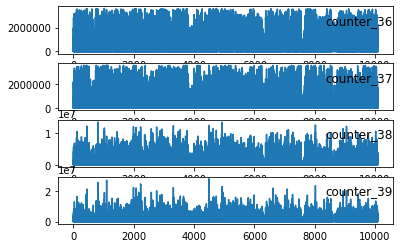

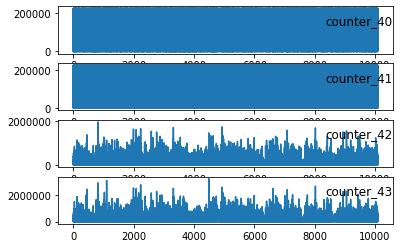

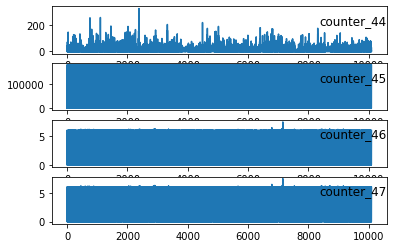

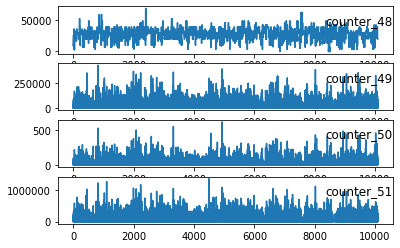

In [13]:
#X axis: all the nodes across all the time ordered (hours/days)
#Y-axis: Signal strength of the counter
#
# Notes: 
# Noticed some counters are in range of 1e6 and others are between 1 and 0

def plot_data(start, end, input_data):
    dataset = input_data.iloc[:, start:end].copy()
    groups = np.arange(dataset.shape[1])
    values = dataset.values
    i = 1
    # plot each column
    pyplot.figure()
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(input_data.node_no, values[:, group])
        pyplot.title(dataset.columns[group], y=0.5, loc='right')
        i += 1
    pyplot.show()
    
for i in range (6,58,4):     
    plot_data(i, i+4, input_data)

# Second: Preprocessing and feature selection


## Feature Selection

### From visualization: 
* The bandwidth is related to the output -> Bandwidth feature
* Node_no is related to the output -> node_no feature
* Day is related to the output -> day feature

### What are the possibilities and the limitations? 
ًWhat could affect the categorization output?
1. The trend in data of one counter in one node across hours: affects / does not affect.
    * fictional scenario: counter value is decreasing accross the day causes the node to have issue #2
    * affect? - we take 24 features for every counter leading to 24 * 51 features
    * does not affect? - we take the average (or apply a certain function to condense the data points) of the counters' data every 24 hour
    
2. The history of one counter in one node across days: affects / does not affect.
    * fictional scenario: the previous day in node 80 was issue #4 so it's likely it's the same issue that day.
    * affect? - we can use a model like LSTM (RNN) that has memory.

3. The nodes location of each other by order: affects / does not affect. 
    * fictional scenario: Issue #1 occurs in node 90 affects node 89 and 90.
    * affect? - we may use CNN or a model that respects space. In that case the whole system (snapshot) of all the nodes in one day will be the input in one feedforward.

4. Since only three days are given, I can't know what is the trend of the data in time.
    * fictional scenario: To choose a feature as "day in the week" or "day in the month" for instance.
    * I assume training data to the model will always be within three days.


In [14]:
# Adding one column named: example_index that increments every 24 count
input_data.insert(0, 'example_index', (input_data.index / 24).astype(int))

In [15]:
#averaging every 24 hour to one number per node per counter
input_data_average_hours = input_data.groupby('example_index').mean().astype(int)

# Inserting issue_no to the left using "inner merge"
# Note: the number of the rows decreased from about 30,000 to about 16,500 since not all the output data corresponded to input data!
In_out_data_hours_avg = pd.merge(input_data_average_hours, output_data, on=['Bandwidth', 'node_no', 'day', 'year','month'], right_index =True, how='inner')

In [16]:
# Preparing the features array
# Since Day, Node #, and Bandwidth are categorical features, we pass them to one hot encoder

def build_feature_array(counters_only_df, In_out_data):
    '''
    Function to create array of features
    
    Parameters:
        counters_only_df : dataframe containaing counters' data
        In_out_data : dataframe containing combination of inputer and output datasets
    Output:
        feature array = [day1, day 2, day3, Bandwidth 10, Bandwidth 20, node_0, ... node_51, counter_0, .. counter_51].values

    '''
        
    # First 3Days and Bandwidth one hot encoding
    onehot = OneHotEncoder(dtype=np.int, sparse=True)
    days_bw_df =  pd.DataFrame(
        onehot.fit_transform(In_out_data[['day', 'Bandwidth']])\
        .toarray(),
        columns=['day 1', 'day 2', 'day 3', 'Bandwidth 10', 'Bandwidth 20'])

    #node number to categorical
    node_no_arr= keras.utils.to_categorical(In_out_data[['node_no']])

    ##concat all features together
    feature_array = np.concatenate((days_bw_df.values,
                                       node_no_arr,
                                       counters_only_df.values), 
                                       axis = 1)
    return feature_array
    
counter_only_avg_hours_df = In_out_data_hours_avg.iloc[:, 6:-1].copy()    
feature_array_avg_hours = build_feature_array(counter_only_avg_hours_df, In_out_data_hours_avg)
label_array_avg_hours = In_out_data_hours_avg['Issue_no']

C:\Users\micha\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


## Data Preprocessing
I experimented with different feature scaling techniques:   
StandardScaler, RobustScaler, MinMaxScaler(0-1)
I chose StandardScaler as it goes well with Adam optimizer.

In [17]:
def preprocessing_data (feature_array, label_array, scaler):
    '''
    Function to 
    (1) divide the rows of both features array and label array to train, test, and validation
    (2) encode output labels to_categorical
    (3) apply feature scaling
    
    Parameters:
        feature_array : array containaing all the features
        label_array : dataframe containing one column: Issue_no
        scaler : string either: 'RobustScaler', 'StandardScaler', or ''
    Output:
        X_train, X_test, X_val
        Y_train, Y_test, Y_val

    '''
    # splitting the features and labels to train and test
    X_train, X_test, y_train, y_test = train_test_split(feature_array, label_array, test_size = 0.1)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1)
    
    #encoding the categorical output to 13 element array (one hot encoding)
    y_train, y_test, y_valid = keras.utils.to_categorical(y_train), keras.utils.to_categorical(y_test), keras.utils.to_categorical(y_valid)
    
    #scaling the features according to the training data
    if scaler == 'RobustScaler':
        scale = preprocessing.RobustScaler().fit(X_train)
    elif scaler == 'StandardScaler':
        scale = preprocessing.StandardScaler().fit(X_train)
    else:
        scale = preprocessing.MinMaxScaler().fit(X_train)
        
    X_train, X_test, X_valid = scale.transform(X_train), scale.transform(X_test), scale.transform(X_valid)
    
    return X_train, X_test, X_valid, y_train, y_test, y_valid
    
X_train, X_test, X_valid, y_train, y_test, y_valid = preprocessing_data (feature_array_avg_hours, label_array_avg_hours, 'StandardScaler')  



# Modeling

## What algorithm to use?

1. SVM, is used with sensors data but it takes along time to train as it's linear. Although we can use non-linear kernels. This problem has so many features for SVM to work with.

2. In order to utilize the relatively large dataset, a simply one dense layer (deeplearning) could be used. 

In [192]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    EARLY_STOPPING are set by the constants at the top of the
    section. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    # Because the problem is a multi-class, single-label prediction,
    # we use categorical_crossentropy as the loss function and softmax as the final activation function.
    model.compile(optimizer='adam'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=EPOCHS
                       , validation_data=(X_valid, y_valid)
                       , verbose=VERBOSE
                       , class_weight = class_weight
                       , callbacks = [EARLY_STOPPING])
    return history

def eval_metric(history, model):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    
    pyplot.subplot(211)
    pyplot.title('Loss / categorical_crossentropy')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'],label='validation')
    pyplot.xlabel('Epoch number')
    pyplot.ylabel('loss')
    pyplot.title('Comparing training and validation ' + 'loss')
    pyplot.legend()

    pyplot.subplot(212)
    pyplot.title('Accuracy')
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='validation')
    pyplot.xlabel('Epoch number')
    pyplot.ylabel('accuracy')
    pyplot.title('Comparing training and validation ' + 'accuracy')
    pyplot.legend()
    pyplot.show()

    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, validation_acc = model.evaluate(X_valid, y_valid, verbose=0)
    print('Train: %.3f, validation: %.3f' % (train_acc, validation_acc))
    return validation_acc, history.history['val_loss']
    
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

def define_dense_model(unit, n_features, n_outputs):
    '''
    Function to return model
    
    Parameters:
        units : each number map to a different dense unit
        n_features: number of features
        n_outputs: number of outputs
    Output:
        Dense model with dropout 0.5
    '''
    model = Sequential()
    
    if unit ==0 :
          model.add(Dense(3, activation='relu', input_dim=n_features))  
    elif unit ==1 : 
         model.add(Dense(6, activation='relu', input_dim=n_features))  
    elif unit ==2 : 
         model.add(Dense(9, activation='relu', input_dim=n_features))  
    elif unit ==3 : 
         model.add(Dense(12, activation='relu', input_dim=n_features))  
    elif unit ==4 : 
         model.add(Dense(16, activation='relu', input_dim=n_features))  
    elif unit ==5 : 
         model.add(Dense(24, activation='relu', input_dim=n_features))  
    elif unit ==6 : 
         model.add(Dense(64, activation='relu', input_dim=n_features))  
    elif unit ==7 : 
         model.add(Dense(128, activation='relu', input_dim=n_features))  
    elif unit ==8 : 
         model.add(Dense(256, activation='relu', input_dim=n_features))  
    else: 
         model.add(Dense(512, activation='relu', input_dim=n_features))  
    
    model.add(Dropout(0.5))
    model.add(Dense(n_outputs, activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  
    return model


We are trying different dense units in order to see which gives the highest validation accuracy and/or validation loss.

Train on 13569 samples, validate on 1508 samples
Epoch 1/25
13569/13569 [==============================] - 5s 348us/step - loss: 2.6819 - accuracy: 0.2660 - val_loss: 2.4392 - val_accuracy: 0.3700
Epoch 2/25
13569/13569 [==============================] - 3s 248us/step - loss: 2.1225 - accuracy: 0.3473 - val_loss: 1.9595 - val_accuracy: 0.3906
Epoch 3/25
13569/13569 [==============================] - 3s 250us/step - loss: 1.8374 - accuracy: 0.3651 - val_loss: 1.7780 - val_accuracy: 0.4244
Epoch 4/25
13569/13569 [==============================] - 3s 247us/step - loss: 1.7299 - accuracy: 0.3701 - val_loss: 1.6963 - val_accuracy: 0.4436
Epoch 5/25
13569/13569 [==============================] - 3s 243us/step - loss: 1.6715 - accuracy: 0.3798 - val_loss: 1.6261 - val_accuracy: 0.4549
Epoch 6/25
13569/13569 [==============================] - 3s 238us/step - loss: 1.6259 - accuracy: 0.3770 - val_loss: 1.5726 - val_accuracy: 0.4649
Epoch 7/25
13569/13569 [==============================] - 3s 25

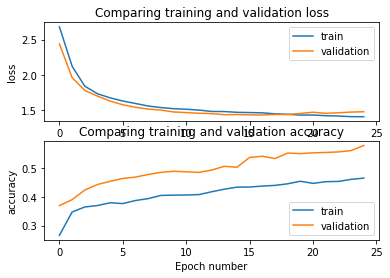

Train: 0.616, validation: 0.580
Train on 13569 samples, validate on 1508 samples
Epoch 1/25
13569/13569 [==============================] - 5s 356us/step - loss: 2.4990 - accuracy: 0.2648 - val_loss: 2.1428 - val_accuracy: 0.3906
Epoch 2/25
13569/13569 [==============================] - 3s 245us/step - loss: 1.9945 - accuracy: 0.3665 - val_loss: 1.7960 - val_accuracy: 0.4363
Epoch 3/25
13569/13569 [==============================] - 3s 246us/step - loss: 1.7211 - accuracy: 0.3902 - val_loss: 1.6433 - val_accuracy: 0.4635
Epoch 4/25
13569/13569 [==============================] - 4s 263us/step - loss: 1.5917 - accuracy: 0.4128 - val_loss: 1.5322 - val_accuracy: 0.5027
Epoch 5/25
13569/13569 [==============================] - 3s 243us/step - loss: 1.5120 - accuracy: 0.4340 - val_loss: 1.4638 - val_accuracy: 0.5206
Epoch 6/25
13569/13569 [==============================] - 3s 250us/step - loss: 1.4370 - accuracy: 0.4505 - val_loss: 1.4171 - val_accuracy: 0.5385
Epoch 7/25
13569/13569 [=======

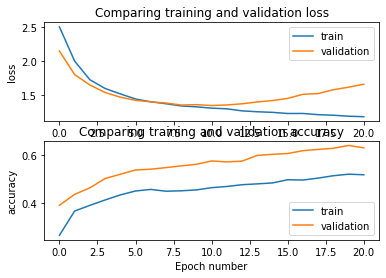

Train: 0.685, validation: 0.631
Train on 13569 samples, validate on 1508 samples
Epoch 1/25
13569/13569 [==============================] - 5s 353us/step - loss: 2.3280 - accuracy: 0.2978 - val_loss: 1.7858 - val_accuracy: 0.4271
Epoch 2/25
13569/13569 [==============================] - 3s 255us/step - loss: 1.7295 - accuracy: 0.4072 - val_loss: 1.5287 - val_accuracy: 0.5020
Epoch 3/25
13569/13569 [==============================] - 3s 254us/step - loss: 1.4996 - accuracy: 0.4538 - val_loss: 1.3621 - val_accuracy: 0.5458
Epoch 4/25
13569/13569 [==============================] - 3s 256us/step - loss: 1.3712 - accuracy: 0.4883 - val_loss: 1.2739 - val_accuracy: 0.5882
Epoch 5/25
13569/13569 [==============================] - 3s 258us/step - loss: 1.2868 - accuracy: 0.5148 - val_loss: 1.2180 - val_accuracy: 0.6233
Epoch 6/25
13569/13569 [==============================] - 4s 258us/step - loss: 1.2013 - accuracy: 0.5360 - val_loss: 1.1952 - val_accuracy: 0.6326
Epoch 7/25
13569/13569 [=======

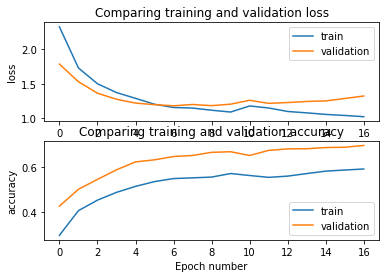

Train: 0.779, validation: 0.696
Train on 13569 samples, validate on 1508 samples
Epoch 1/25
13569/13569 [==============================] - 5s 363us/step - loss: 2.4375 - accuracy: 0.2722 - val_loss: 1.8426 - val_accuracy: 0.4151
Epoch 2/25
13569/13569 [==============================] - 4s 263us/step - loss: 1.6873 - accuracy: 0.4247 - val_loss: 1.5052 - val_accuracy: 0.5020
Epoch 3/25
13569/13569 [==============================] - 3s 257us/step - loss: 1.4243 - accuracy: 0.4877 - val_loss: 1.3510 - val_accuracy: 0.5736
Epoch 4/25
13569/13569 [==============================] - 4s 263us/step - loss: 1.2941 - accuracy: 0.5240 - val_loss: 1.2841 - val_accuracy: 0.6061
Epoch 5/25
13569/13569 [==============================] - 4s 261us/step - loss: 1.1967 - accuracy: 0.5490 - val_loss: 1.2420 - val_accuracy: 0.6313
Epoch 6/25
13569/13569 [==============================] - 4s 273us/step - loss: 1.1380 - accuracy: 0.5597 - val_loss: 1.2469 - val_accuracy: 0.6492
Epoch 7/25
13569/13569 [=======

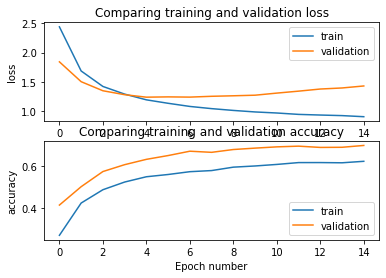

Train: 0.805, validation: 0.697
Train on 13569 samples, validate on 1508 samples
Epoch 1/25
13569/13569 [==============================] - 5s 374us/step - loss: 2.3578 - accuracy: 0.2808 - val_loss: 1.7738 - val_accuracy: 0.4748
Epoch 2/25
13569/13569 [==============================] - 4s 268us/step - loss: 1.6394 - accuracy: 0.4479 - val_loss: 1.3569 - val_accuracy: 0.5796
Epoch 3/25
13569/13569 [==============================] - 4s 259us/step - loss: 1.3262 - accuracy: 0.5325 - val_loss: 1.1733 - val_accuracy: 0.6359
Epoch 4/25
13569/13569 [==============================] - 4s 282us/step - loss: 1.1495 - accuracy: 0.5828 - val_loss: 1.1132 - val_accuracy: 0.6691
Epoch 5/25
13569/13569 [==============================] - 4s 299us/step - loss: 1.0419 - accuracy: 0.6087 - val_loss: 1.1058 - val_accuracy: 0.6830
Epoch 6/25
13569/13569 [==============================] - 4s 308us/step - loss: 0.9640 - accuracy: 0.6353 - val_loss: 1.1220 - val_accuracy: 0.7082
Epoch 7/25
13569/13569 [=======

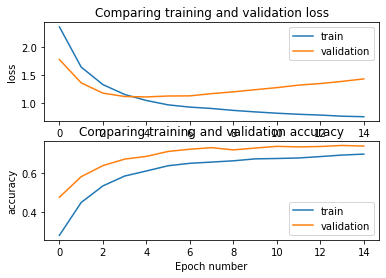

Train: 0.837, validation: 0.735
Train on 13569 samples, validate on 1508 samples
Epoch 1/25
13569/13569 [==============================] - 5s 400us/step - loss: 2.6024 - accuracy: 0.2845 - val_loss: 1.9514 - val_accuracy: 0.4503
Epoch 2/25
13569/13569 [==============================] - 4s 299us/step - loss: 1.5757 - accuracy: 0.5062 - val_loss: 1.3339 - val_accuracy: 0.6320
Epoch 3/25
13569/13569 [==============================] - 4s 330us/step - loss: 1.1606 - accuracy: 0.6323 - val_loss: 1.2071 - val_accuracy: 0.6830
Epoch 4/25
13569/13569 [==============================] - 4s 306us/step - loss: 0.9555 - accuracy: 0.6802 - val_loss: 1.2054 - val_accuracy: 0.7135
Epoch 5/25
13569/13569 [==============================] - 4s 308us/step - loss: 0.8431 - accuracy: 0.7165 - val_loss: 1.2070 - val_accuracy: 0.7301
Epoch 6/25
13569/13569 [==============================] - 4s 299us/step - loss: 0.7720 - accuracy: 0.7324 - val_loss: 1.2226 - val_accuracy: 0.7401
Epoch 7/25
13569/13569 [=======

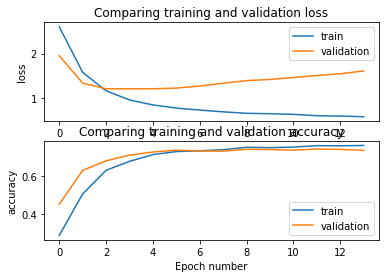

Train: 0.875, validation: 0.739
Train on 13569 samples, validate on 1508 samples
Epoch 1/25
13569/13569 [==============================] - 8s 559us/step - loss: 2.1366 - accuracy: 0.3705 - val_loss: 1.4456 - val_accuracy: 0.6015
Epoch 2/25
13569/13569 [==============================] - 5s 402us/step - loss: 1.1094 - accuracy: 0.6742 - val_loss: 1.0854 - val_accuracy: 0.7321
Epoch 3/25
13569/13569 [==============================] - 5s 402us/step - loss: 0.6766 - accuracy: 0.7999 - val_loss: 1.1926 - val_accuracy: 0.7613
Epoch 4/25
13569/13569 [==============================] - 5s 400us/step - loss: 0.5317 - accuracy: 0.8314 - val_loss: 1.3190 - val_accuracy: 0.7546
Epoch 5/25
13569/13569 [==============================] - 5s 397us/step - loss: 0.4668 - accuracy: 0.8407 - val_loss: 1.4016 - val_accuracy: 0.7480
Epoch 6/25
13569/13569 [==============================] - 6s 412us/step - loss: 0.4374 - accuracy: 0.8452 - val_loss: 1.4354 - val_accuracy: 0.7500
Epoch 7/25
13569/13569 [=======

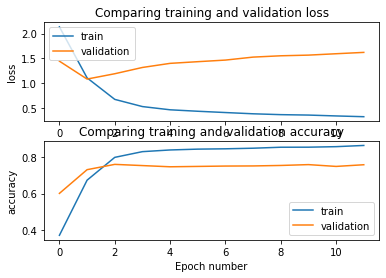

Train: 0.900, validation: 0.759
Train on 13569 samples, validate on 1508 samples
Epoch 1/25
13569/13569 [==============================] - 11s 787us/step - loss: 1.9695 - accuracy: 0.4267 - val_loss: 1.2371 - val_accuracy: 0.6651
Epoch 2/25
13569/13569 [==============================] - 7s 536us/step - loss: 0.8440 - accuracy: 0.7657 - val_loss: 1.1639 - val_accuracy: 0.7500
Epoch 3/25
13569/13569 [==============================] - 7s 534us/step - loss: 0.5191 - accuracy: 0.8375 - val_loss: 1.2567 - val_accuracy: 0.7586
Epoch 4/25
13569/13569 [==============================] - 8s 555us/step - loss: 0.4344 - accuracy: 0.8489 - val_loss: 1.3648 - val_accuracy: 0.7659
Epoch 5/25
13569/13569 [==============================] - 8s 560us/step - loss: 0.3940 - accuracy: 0.8540 - val_loss: 1.4342 - val_accuracy: 0.7540
Epoch 6/25
13569/13569 [==============================] - 8s 553us/step - loss: 0.3682 - accuracy: 0.8575 - val_loss: 1.4465 - val_accuracy: 0.7527
Epoch 7/25
13569/13569 [======

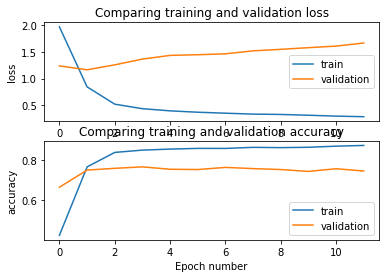

Train: 0.910, validation: 0.745
Train on 13569 samples, validate on 1508 samples
Epoch 1/25
13569/13569 [==============================] - 13s 985us/step - loss: 1.7317 - accuracy: 0.4875 - val_loss: 1.2423 - val_accuracy: 0.7062
Epoch 2/25
13569/13569 [==============================] - 11s 826us/step - loss: 0.6915 - accuracy: 0.8106 - val_loss: 1.3227 - val_accuracy: 0.7553
Epoch 3/25
13569/13569 [==============================] - 11s 806us/step - loss: 0.4656 - accuracy: 0.8455 - val_loss: 1.4008 - val_accuracy: 0.7533
Epoch 4/25
13569/13569 [==============================] - 11s 818us/step - loss: 0.4072 - accuracy: 0.8522 - val_loss: 1.4665 - val_accuracy: 0.7580
Epoch 5/25
13569/13569 [==============================] - 11s 816us/step - loss: 0.3765 - accuracy: 0.8547 - val_loss: 1.4544 - val_accuracy: 0.7507
Epoch 6/25
13569/13569 [==============================] - 13s 945us/step - loss: 0.3634 - accuracy: 0.8534 - val_loss: 1.4973 - val_accuracy: 0.7493
Epoch 7/25
13569/13569 [=

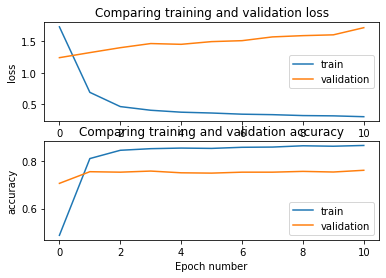

Train: 0.908, validation: 0.761


In [197]:
# Defining the model
from sklearn.metrics import confusion_matrix 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping

VERBOSE, EPOCHS, PATIENCE = 1, 25, 10
EARLY_STOPPING = EarlyStopping(monitor='val_loss', mode='min', verbose=VERBOSE, patience=PATIENCE)
n_features, n_outputs = X_train.shape[1], y_train.shape[1]

class_weight = class_weight.compute_class_weight('balanced', np.unique([np.argmax(y, axis=None, out=None) for y in y_train]),
                                                 [np.argmax(y, axis=None, out=None) for y in y_train])

dense_units=[3, 6, 9, 12, 16, 24, 64, 128, 256, 512]
df = pd.DataFrame(columns=['dense units', 'min epoch', 'validation accuracy', 'loss'])


for i in range (9):
   
    #Defining the model
    model = define_dense_model(i, n_features, n_outputs)
    
    #Fitting the model
    history = deep_model(model, X_train, y_train, X_valid, y_valid)

    #Evaluate the model
    min_epoch = optimal_epoch(history)
    val_acc, loss = eval_metric(history, model)
    
    df.loc[i] = [dense_units[i]] + [min_epoch] + [val_acc] + [loss]


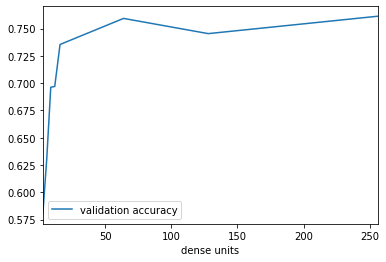

In [200]:
# X axis: Dense units in MLP
# Y axis: accuracy 
# Note: increasing dense units increase accuracy 

df.plot(x='dense units', y='validation accuracy')

Although accuracy increase, validation loss decrease. 
## What is the evaluation metrics used?
I tracked validation accuracy and validation loss In order to create the most accurate "substitute system".
The highest accuracy I got with DL Dense layer is 76.13%

In [ ]:
#Note: I should have used the test data to evaluate my this algorithm with different algorithms (SVM, K means), but they took so long to train so I ended up not using the test data. 